In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import helpers.cusplot as cplt
import scipy.optimize as sco

from functools import partial


## constants (SI)

In [3]:
# general
c = 299792458
m_pr = 938.272 # MeV

# kicker
brho = 1.23 
lgap = 0.1
kick_l = 0.5
N = 20
u0 = 4*np.pi*1e-7

l = 3 # dist. kicker-septum

# charge distribution
sigma = 0.015
delta_x_max = 0.01

# septum
w = 0.005 # 5 mm thickness for DC septum (CERN paper)
# assuming infinte extend in y (valid - 100 mm beam tube > 6 sigma)

In [ ]:
# numeric integration of current fraction 
# incident on septum
d = {}

for delta_x in np.linspace(0,delta_x_max,10):
    I = 0
    for step in np.linspace(2*sigma-w/2, 2*sigma + w/2,10):
        I += np.exp(-(step-delta_x)**2/(2*sigma**2))*w/10
    
    I_norm = 1/(np.sqrt(2*np.pi)*sigma)*I
    
    d[delta_x] = I_norm

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(*zip(*sorted(d.items())))
ax.set_xlabel('delta x [m]')
ax.set_ylabel('fraction')

ax.set_title('int. fraction on {} mm septum'.format(w*1e3))

#convert spat. to curr_off
def dx_to_dI(dx):
    dThet = dx/l
    dI = brho*lgap/(u0*kick_l*N)*dThet
    return round(dI,3)

cplt.add_axis(ax, 'x', dx_to_dI, 'delta I [A]' )

plt.show()

## el. vs. magn. field

In [ ]:
# integrated B-field / E-field norm. to kick angle
M = 1 # 1:MeV, 1e-3: keV, ...

T = np.arange(0,100,10)* M# MeV
p = np.sqrt(T**2+2*T*m_pr) # MeV

mag = p*1e-3/0.3 * M

el = p/m_pr*c*p*1e-3/0.3 * M

ax = plt.gca()
ax.set_xlabel(r'$E$ [MeV]')
ax.set_xticks(T)
ax.set_ylabel(r'$BL/\Theta$ [Tm/rad]')
ax.set_title('electric vs. magnetic field')
ax1 = ax.twinx()
ax1.set_ylabel(r'$EL/\Theta$ [V/rad]')
ax1.spines['right'].set_color('r')

ax.plot(T,mag)
ax1.plot(T,el, c = 'r')
ax.legend(['int., norm. B-field'], loc = 2)
ax1.legend(['int., norm. E-field'], loc = 4)

plt.savefig('/home/marius/Jülich/Multiplexer/Plots/elvsmagn')
plt.show()

## quadrupole deflection study

In [ ]:
k = 10/1.23
l_lens = 0.3
l_dist = np.arange(0,2,0.1)
l_dist_2 = np.arange(0,3,0.1)
l_kick = 0.5
l_bq = np.arange(l_kick,3,0.1)


fig, ax = plt.subplots(2,2, figsize = (10,10))
angles = np.arange(0.01,0.05,0.01)
l_d_f = 1

def xbar(k,l_lens,l_dist,l_kick,theta):
    return k*l_lens*(l_dist*theta + l_kick*theta/2)

for theta in angles:
    ax[0,0].plot(l_dist,xbar(k,l_lens,l_dist,l_kick,theta))
    ax[0,1].plot(l_dist_2,(xbar(k,l_lens,l_d_f,l_kick,theta)+theta)*l_dist_2+l_d_f*theta + l_kick*theta/2)
    

ax[0,0].set_xlabel('l_kq [m]')
ax[0,0].set_ylabel('perm. [rad]')    

ax[0,1].set_xlabel('l_qk [m]')
ax[0,1].set_ylabel('delta x c.o. [m]')

ax[1,0].plot(l_bq,k*l_lens/l_bq)
ax[1,0].set_xlabel('l_bq [m]')
ax[1,0].set_ylabel('focal length [m]')
    
    
ax[0,0].legend(['{} rad'.format(item) for item in angles.tolist()])
ax[0,1].text(0.1,0.9,'l_kq = {}'.format(l_d_f),transform=ax[0,1].transAxes)

# iterative solution (distances)
d = {}
d[0] = []
d[1] = []
d[2] = []

angle = 0.04

for lbar in np.arange(0,2,0.02):
            lbar3 = 0
            #co = xbar*focal_length+x
            #co_wo = angle*lbar3
            co = xbar(k,l_lens,lbar3,l_kick,angle)*(k*l_lens)**2/(l_kick+lbar3+lbar)+lbar3*angle*l_kick*angle/2
            while co <= 0.45:
                lbar3 = lbar3 + 0.02
                co = xbar(k,l_lens,lbar3,l_kick,angle)*(k*l_lens)**2/(l_kick+lbar3+lbar)+lbar3*angle*l_kick*angle/2
            
            d[0].append((lbar,round(lbar3,3)))
            d[1].append((lbar,round((k*l_lens)**2/(l_kick+lbar3+lbar),3)))
            d[2].append((lbar,round(co,3)))

ax[1,1].plot(*zip(*d[0]))
ax1 = ax[1,1].twinx()
ax1.plot(*zip(*d[1]),c='r')
ax1.spines['right'].set_color('r')
ax[1,1].set_xlabel('1st quad - kicker [m]')
ax[1,1].set_ylabel('kicker - 2nd quad [m]')
ax[1,1].text(0.1,0.9,"theta = {}".format(angle),transform=ax[1,1].transAxes)
            
            
            
plt.show()

### write ion optics class from here

## quadrupole triplet study

In [4]:
# matrices

def qf(L,k,t=False):
    
    c = np.cos(np.sqrt(k)*L)
    s = np.sin(np.sqrt(k)*L)
    
    ch = np.cosh(np.sqrt(k)*L)
    sh = np.sinh(np.sqrt(k)*L)
    
    M11 = c
    M12 = s/np.sqrt(k)
    M21 = -np.sqrt(k)*s
    M22 = c
    
    M33 = ch
    M34 = sh/np.sqrt(k)
    M43 = np.sqrt(k)*sh
    M44 = ch
    
    if t:
        M11 = 1
        M12 = 0
        M21 = -k*L
        M22 = 1
        
        M33 = 1
        M34 = 0
        M43 = k*L
        M44 = 1
    
    
    
    M = np.array([[M11,M12,0,0],[M21,M22,0,0],[0,0,M33,M34],[0,0,M43,M44]])
    
    return M

def qdf(L,k,t=False):
    
    ch = np.cosh(np.sqrt(k)*L)
    sh = np.sinh(np.sqrt(k)*L)
    
    c = np.cos(np.sqrt(k)*L)
    s = np.sin(np.sqrt(k)*L)
    
    M11 = ch
    M12 = sh/np.sqrt(k)
    M21 = np.sqrt(k)*sh
    M22 = ch
    
    M33 = c
    M34 = s/np.sqrt(k)
    M43 = -np.sqrt(k)*s
    M44 = c
    
    if t:
        M11 = 1
        M12 = 0
        M21 = k*L
        M22 = 1
        
        M33 = 1
        M34 = 0
        M43 = -k*L
        M44 = 1
    
    
    
    M = np.array([[M11,M12,0,0],[M21,M22,0,0],[0,0,M33,M34],[0,0,M43,M44]])
    
    return M

def drift(L):
    
    M11 = 1
    M12 = L
    M21 = 0
    M22 = 1
    
    M33 = 1
    M34 = L
    M43 = 0
    M44 = 1
    
    M = np.array([[M11,M12,0,0],[M21,M22,0,0],[0,0,M33,M34],[0,0,M43,M44]])
    
    return M
    
def bl(matrices):
    
    for index in range(len(matrices)):
        try:
            matrices[index+1] = np.matmul(matrices[index+1],matrices[index])
        except: pass
    
    return matrices[-1]

def zplanes(matrix):

    z1x = (matrix[1][1]-1)/matrix[1][0]
    z2x = (matrix[0][0]-1)/matrix[1][0]
    
    z1y = (matrix[3][3]-1)/matrix[3][2]
    z2y = (matrix[2][2]-1)/matrix[3][2]
    
    return (z1x,z2x),(z1y,z2y)

def thin(matrix):
    
    zx,zy = zplanes(matrix)
    
    Z1x = drift(-zx[0])
    Z2x = drift(-zx[1])
    
    Z1y = drift(-zy[0])
    Z2y = drift(-zy[1])
    
    thinx = bl([Z1x,matrix,Z2x])
    thiny = bl([Z1y,matrix,Z2y])
    
    return thinx,thiny
    
        



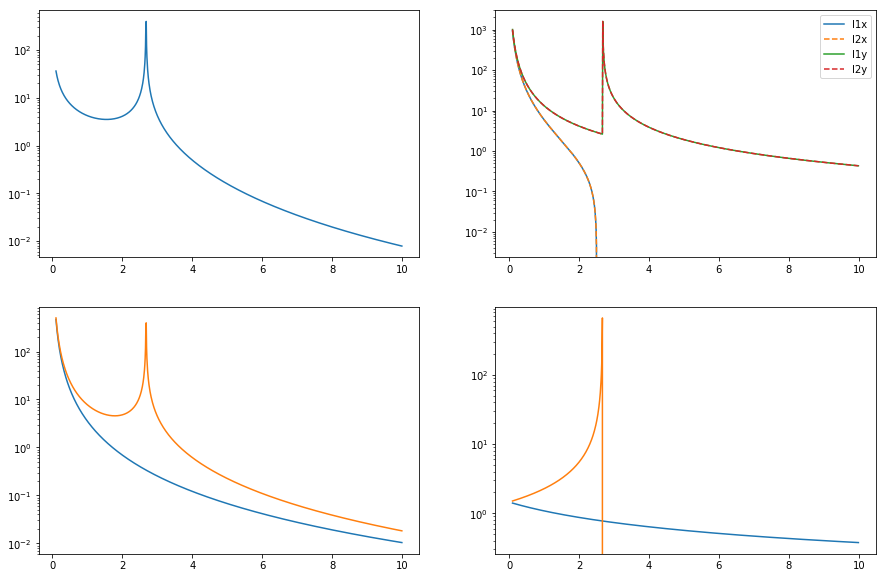

In [14]:
k = np.arange(0.1,10,0.01)
d = 1
L = 0.3
zeros, fx, fy, l1x, l1y, l2x, l2y, zxl, zyl = ([] for i in range(9))

t = False

for i in k:
    
    
    tripl = bl([qdf(L,i,t),drift(d),qf(L,2*i,t),drift(d),qdf(L,i,t)])
    
    thinx,thiny = thin(tripl)
    
    
    zx,zy = zplanes(tripl)
    
    zeros.append(np.sqrt((np.abs(1/thiny[3][2])-np.abs(1/thinx[1][0]))**2))
    fx.append(np.abs(1/thinx[1][0]))
    fy.append(np.abs(1/thiny[3][2]))
    l1x.append(2*np.abs(1/thinx[1][0])-zx[0])
    l1y.append(2*np.abs(1/thiny[3][2])-zy[0])
    l2x.append(2*np.abs(1/thinx[1][0])-zx[1])
    l2y.append(2*np.abs(1/thiny[3][2])-zy[1])
    zxl.append(zx[0])
    zyl.append(zy[0])
    
    
    
    
fig, axes = plt.subplots(2,2, figsize = (15,10))    
axes[0][0].semilogy(k,zeros)
axes[0][1].semilogy(k,l1x)
axes[0][1].semilogy(k,l2x,'--')
axes[0][1].semilogy(k,l1y)
axes[0][1].semilogy(k,l2y,'--')


axes[1][0].semilogy(k,fx)
axes[1][0].semilogy(k,fy)

axes[1][1].semilogy(k,zxl)
axes[1][1].semilogy(k,zyl)

axes[0][1].legend(['l1x','l2x','l1y','l2y'])
# difference of focal lengths vs. k
# Problem:  large deviation in fx,fy / lx,ly
#plt.savefig('/home/marius/Jülich/Multiplexer/Plots/Qtripletdists.png',format = 'png', dpi=300)
plt.show()

In [15]:
step = 120
(k[step],l1x[step],l2x[step],l1y[step],l2y[step])
#TODO implement fitting routine to get lx = ly

(1.2999999999999994,
 2.838640537012274,
 2.8386405370122745,
 8.405583850589629,
 8.405583850589629)

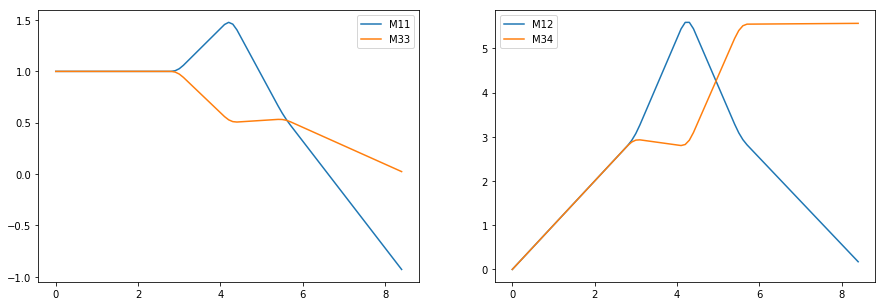

In [18]:
l = 2.8
k_fix = 1.3
L = 0.3
d = 1

#TODO: A problem persists regarding the step size

lengths = [l,L,d,L,d,L,l]
elements = [drift,partial(qdf, k=k_fix),drift,partial(qf, k=2*k_fix),drift,partial(qdf, k=k_fix),drift]

def Mplot(blist,llist):
    '''calculate s-dependent matrix elements of given beam line with specified lenghts.
    @param blist: list of functions of ion optical elements (careful: elements with multiple input params: partial)
    @param llist: list of lenghts of ion optical elements
    @return: 
        s: propagation
        first tuple: horizontal transport matrix elements
        second tuple: horizontal transport matrix elements
        
    '''
    M11, M12, M21, M22, M33, M34, M43, M44 = ([] for i in range(8))
    
    dec = max([str(i)[::-1].find('.') for i in llist])
    step = 10**-dec
    
    M_static = [ele(length) for ele,length in zip(blist,llist)]
    M_dyn = lambda x: [ele(x) for ele in blist]
    # save static elements in list and multiply current l-dependent matrix with it
    for i,l in enumerate(llist):
        dist = np.arange(0,l,step)
        for d in dist:
            stat = M_static[:i]
            dyn = [M_dyn(d)[i]]
            stat.extend(dyn)
            
            M_temp = bl(stat)

            M11.append(M_temp[0][0])
            M12.append(M_temp[0][1])
            M21.append(M_temp[1][0])
            M22.append(M_temp[1][1])
            
            M33.append(M_temp[2][2])
            M34.append(M_temp[2][3])
            M43.append(M_temp[3][2])
            M44.append(M_temp[3][3])
            
            
            
    s = np.arange(0,round(sum(llist),dec),step)
        
    return s,(M11,M12,M21,M22),(M33,M34,M43,M44)


fig, axes = plt.subplots(1,2, figsize=(15,5))


axes[0].plot(Mplot(elements,lengths)[0],Mplot(elements,lengths)[1][0])
axes[0].plot(Mplot(elements,lengths)[0],Mplot(elements,lengths)[2][0])

axes[1].plot(Mplot(elements,lengths)[0],Mplot(elements,lengths)[1][1])
axes[1].plot(Mplot(elements,lengths)[0],Mplot(elements,lengths)[2][1])

axes[0].legend(['M11','M33'])
axes[1].legend(['M12','M34'])


plt.show()
        
    


### optmization

In [19]:
l = 2.8
L = 0.3
d = 1

def test(k):
    lengths = [l,L,d,L,d,L,l]
    elements = [drift,partial(qdf, k=k[0]),drift,partial(qf, k=2*k[0]),drift,partial(qdf, k=k[0]),drift]
    
    res = (Mplot(elements,lengths)[1][1][-1])**2 + (Mplot(elements,lengths)[2][1][-1])**2
    
    return res

sco.minimize(test,[1.3],tol=1e-3)

      fun: 27.425300886206703
 hess_inv: array([[0.00211645]])
      jac: array([-0.00013542])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([1.43026233])